In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
from xhistogram.xarray import histogram

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

In [2]:
path_root='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'

control,machine_target='OM4p5_CORE2_IAF_gzCOBALT-Control-062321','gfdl.ncrc4-intel16-prod'
case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-013022','gfdl.ncrc4-intel19-prod'

In [3]:
short_casename=case.replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-013022":
    fig_casename='ms_gzCOBALT'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-013022 ms_gzCOBALT


In [4]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [5]:
tmpdir = '/work/Jessica.Luo/tmp/'+case
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022


In [6]:
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_month_z', 'ocean_cobalt_omip_2d', \
             'ocean_cobalt_fluxes_int', 'ocean_cobalt_fdet_100', 'ocean_cobalt_tracers_int'] 

pp_dates='1988-2007'
#pp_dates='1968-1972'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension


In [7]:
if not files:
    pp_path=os.path.join(path_root, case, machine_target, 'pp')
    
    files=[glob(pp_path + '/' + d + '/av/monthly_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    files=sorted([f for fi in files for f in fi]) # nested list comprehension
    print(files)


In [8]:
grid_file=os.path.join(path_root, case, machine_target, 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
grid=xr.open_dataset(grid_file)

In [9]:
tmpdir = '/work/Jessica.Luo/tmp/'+control
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)
    
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_month_z', 'ocean_cobalt_omip_2d', \
             'ocean_cobalt_fluxes_int', 'ocean_cobalt_fdet_100', 'ocean_cobalt_tracers_int'] 

pp_dates='1988-2007'
#pp_dates='1968-1972'

c_files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension

if not c_files:
    pp_path=os.path.join(path_root, control, machine_target, 'pp')
    
    c_files=[glob(pp_path + '/' + d + '/av/monthly_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension

#print(c_files)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321


In [10]:
dc=xr.open_mfdataset(c_files, combine='by_coords')

In [11]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})

In [12]:
import string
alphabet=list(string.ascii_lowercase)

## Observations

In [13]:
obs_chl = xr.open_dataset('/work/jyl/validation_data/SO_Blended_Chl/globcolour_soblend_mc_esm4grid.nc')
obs_chl = obs_chl.mean(dim='time')

In [14]:
obs_no3 = xr.open_dataset('/work/jyl/validation_data/WOA/nitrate_woa_esm4grid.nc') # micromoles per kilogram, or micromol/L, equivalent to 1e-3 mol m-3
obs_po4 = xr.open_dataset('/work/jyl/validation_data/WOA/phosphate_woa_esm4grid.nc')
obs_sio3 = xr.open_dataset('/work/jyl/validation_data/WOA/silicate_woa_esm4grid.nc')

## Bias, RMSE, and Pearson's R calculations

In [15]:
from scipy.stats import pearsonr

In [16]:
chl_ann = ds.chl.mean(dim='time') * 1e6 # kg chl m-3 to mg chl m-3
no3_ann = ds.no3.mean(dim='time') * 1e3 # mol m-3 to micromol kg-1
po4_ann = ds.po4.mean(dim='time') * 1e3 # mol m-3 to micromol kg-1
sio3_ann = ds.si.mean(dim='time') * 1e3 # mol m-3 to micromol kg-1

c_chl_ann = dc.chl.mean(dim='time') * 1e6 # kg chl m-3 to mg chl m-3
c_no3_ann = dc.no3.mean(dim='time') * 1e3 # mol m-3 to micromol kg-1
c_po4_ann = dc.po4.mean(dim='time') * 1e3 # mol m-3 to micromol kg-1
c_sio3_ann = dc.si.mean(dim='time') * 1e3 # mol m-3 to micromol kg-1

In [17]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [18]:
# chlorophyll
log_gzchl = np.log10(chl_ann.isel(z_l=0))
log_obschl = np.log10(obs_chl.chl)
log_ctrlchl = np.log10(c_chl_ann.isel(z_l=0))

chl_bias = (log_gzchl - log_obschl).mean()
c_chl_bias = (log_ctrlchl - log_obschl).mean()
chl_rmse = rmse(log_gzchl, log_obschl)
c_chl_rmse = rmse(log_ctrlchl, log_obschl)

print('mean chlorophyll bias (GZ-COBALT): ' + str(np.round(chl_bias.values,3)) + ' and RMSE: ' + str(np.round(chl_rmse.values,3)))
print('mean chlorophyll bias (COBALT Ctrl): ' + str(np.round(c_chl_bias.values,3)) + ' and RMSE: '+ str(np.round(c_chl_rmse.values,3)))

mean chlorophyll bias (GZ-COBALT): 0.003 and RMSE: 0.35
mean chlorophyll bias (COBALT Ctrl): 0.014 and RMSE: 0.351


In [20]:
X=np.log10(chl_ann.isel(z_l=0).stack(z=('xh','yh')))
Y=np.log10(obs_chl.chl.stack(z=('xh','yh')))
mask = np.logical_and(~np.isnan(X.values),~np.isnan(Y.values))
chl_pearsonsR = pearsonr(X[mask], Y[mask])[0]

X=np.log10(c_chl_ann.isel(z_l=0).stack(z=('xh','yh')))
Y=np.log10(obs_chl.chl.stack(z=('xh','yh')))
mask = np.logical_and(~np.isnan(X.values),~np.isnan(Y.values))
c_chl_pearsonsR = pearsonr(X[mask], Y[mask])[0]

print('chlorophyll correlation (GZ-COBALT): ' + str(np.round(chl_pearsonsR,3)))
print('chlorophyll correlation (COBALT Ctrl): ' + str(np.round(c_chl_pearsonsR,3)))

chlorophyll correlation (GZ-COBALT): 0.718
chlorophyll correlation (COBALT Ctrl): 0.714


In [21]:
# no3
no3_bias = (no3_ann.isel(z_l=0) - obs_no3.n_an.isel(z_l=0)).mean()
c_no3_bias = (c_no3_ann.isel(z_l=0) - obs_no3.n_an.isel(z_l=0)).mean()
no3_rmse = rmse(no3_ann.isel(z_l=0),obs_no3.n_an.isel(z_l=0))
c_no3_rmse = rmse(c_no3_ann.isel(z_l=0),obs_no3.n_an.isel(z_l=0))

print('mean no3 bias (GZ-COBALT): ' + str(np.round(no3_bias.values,3)) + ' and RMSE: ' + str(np.round(no3_rmse.values,2)))
print('mean no3 bias (COBALT Ctrl): ' + str(np.round(c_no3_bias.values,3)) + ' and RMSE: '+ str(np.round(c_no3_rmse.values,2)))

mean no3 bias (GZ-COBALT): 0.481 and RMSE: 2.03
mean no3 bias (COBALT Ctrl): 0.469 and RMSE: 2.03


In [22]:
X=no3_ann.isel(z_l=0).stack(z=('xh','yh'))
Y=obs_no3.n_an.isel(z_l=0).stack(z=('xh','yh'))
mask = np.logical_and(~np.isnan(X.values),~np.isnan(Y.values))
no3_pearsonsR = pearsonr(X[mask], Y[mask])[0]

X=c_no3_ann.isel(z_l=0).stack(z=('xh','yh'))
Y=obs_no3.n_an.isel(z_l=0).stack(z=('xh','yh'))
mask = np.logical_and(~np.isnan(X.values),~np.isnan(Y.values))
c_no3_pearsonsR = pearsonr(X[mask], Y[mask])[0]

print('no3 correlation (GZ-COBALT): ' + str(np.round(no3_pearsonsR,3)))
print('no3 correlation (COBALT Ctrl): ' + str(np.round(c_no3_pearsonsR,3)))

no3 correlation (GZ-COBALT): 0.982
no3 correlation (COBALT Ctrl): 0.982


In [23]:
# po4
po4_bias = (po4_ann.isel(z_l=0) - obs_po4.p_an.isel(z_l=0)).mean()
c_po4_bias = (c_po4_ann.isel(z_l=0) - obs_po4.p_an.isel(z_l=0)).mean()
po4_rmse = rmse(po4_ann.isel(z_l=0),obs_po4.p_an.isel(z_l=0))
c_po4_rmse = rmse(c_po4_ann.isel(z_l=0),obs_po4.p_an.isel(z_l=0))

print('mean po4 bias (GZ-COBALT): ' + str(np.round(po4_bias.values,3)) + ' and RMSE: ' + str(np.round(po4_rmse.values,3)))
print('mean po4 bias (COBALT Ctrl): ' + str(np.round(c_po4_bias.values,3)) + ' and RMSE: '+ str(np.round(c_po4_rmse.values,3)))

mean po4 bias (GZ-COBALT): -0.058 and RMSE: 0.212
mean po4 bias (COBALT Ctrl): -0.066 and RMSE: 0.216


In [24]:
X=po4_ann.isel(z_l=0).stack(z=('xh','yh'))
Y=obs_po4.p_an.isel(z_l=0).stack(z=('xh','yh'))
mask = np.logical_and(~np.isnan(X.values),~np.isnan(Y.values))
po4_pearsonsR = pearsonr(X[mask], Y[mask])[0]

X=c_po4_ann.isel(z_l=0).stack(z=('xh','yh'))
Y=obs_po4.p_an.isel(z_l=0).stack(z=('xh','yh'))
mask = np.logical_and(~np.isnan(X.values),~np.isnan(Y.values))
c_po4_pearsonsR = pearsonr(X[mask], Y[mask])[0]

print('po4 correlation (GZ-COBALT): ' + str(np.round(po4_pearsonsR,3)))
print('po4 correlation (COBALT Ctrl): ' + str(np.round(c_po4_pearsonsR,3)))

po4 correlation (GZ-COBALT): 0.962
po4 correlation (COBALT Ctrl): 0.962


In [25]:
# sio3
sio3_bias = (sio3_ann.isel(z_l=0) - obs_sio3.i_an.isel(z_l=0)).mean()
c_sio3_bias = (c_sio3_ann.isel(z_l=0) - obs_sio3.i_an.isel(z_l=0)).mean()
sio3_rmse = rmse(sio3_ann.isel(z_l=0),obs_sio3.i_an.isel(z_l=0))
c_sio3_rmse = rmse(c_sio3_ann.isel(z_l=0),obs_sio3.i_an.isel(z_l=0))

print('mean sio3 bias (GZ-COBALT): ' + str(np.round(sio3_bias.values,3)) + ' and RMSE: ' + str(np.round(sio3_rmse.values,3)))
print('mean sio3 bias (COBALT Ctrl): ' + str(np.round(c_sio3_bias.values,3)) + ' and RMSE: '+ str(np.round(c_sio3_rmse.values,3)))

mean sio3 bias (GZ-COBALT): 2.745 and RMSE: 8.351
mean sio3 bias (COBALT Ctrl): 2.54 and RMSE: 8.223


In [26]:
X=sio3_ann.isel(z_l=0).stack(z=('xh','yh'))
Y=obs_sio3.i_an.isel(z_l=0).stack(z=('xh','yh'))
mask = np.logical_and(~np.isnan(X.values),~np.isnan(Y.values))
sio3_pearsonsR = pearsonr(X[mask], Y[mask])[0]

X=c_sio3_ann.isel(z_l=0).stack(z=('xh','yh'))
Y=obs_sio3.i_an.isel(z_l=0).stack(z=('xh','yh'))
mask = np.logical_and(~np.isnan(X.values),~np.isnan(Y.values))
c_sio3_pearsonsR = pearsonr(X[mask], Y[mask])[0]

print('sio3 correlation (GZ-COBALT): ' + str(np.round(sio3_pearsonsR,3)))
print('sio3 correlation (COBALT Ctrl): ' + str(np.round(c_sio3_pearsonsR,3)))

sio3 correlation (GZ-COBALT): 0.941
sio3 correlation (COBALT Ctrl): 0.941


## Figure - Compare surface chlorophyll and nutrients with control and with obs

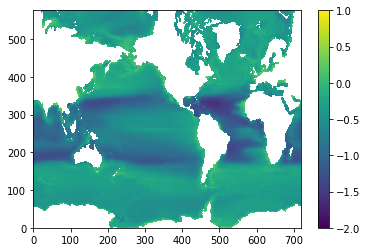

In [27]:
plt.pcolormesh(np.log10(chl_ann.isel(z_l=0)),vmax=1,vmin=-2)
plt.colorbar()

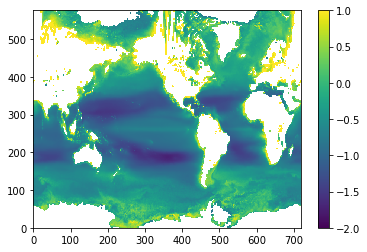

In [28]:
plt.pcolormesh(np.log10(obs_chl.chl),vmax=1,vmin=-2)
plt.colorbar()

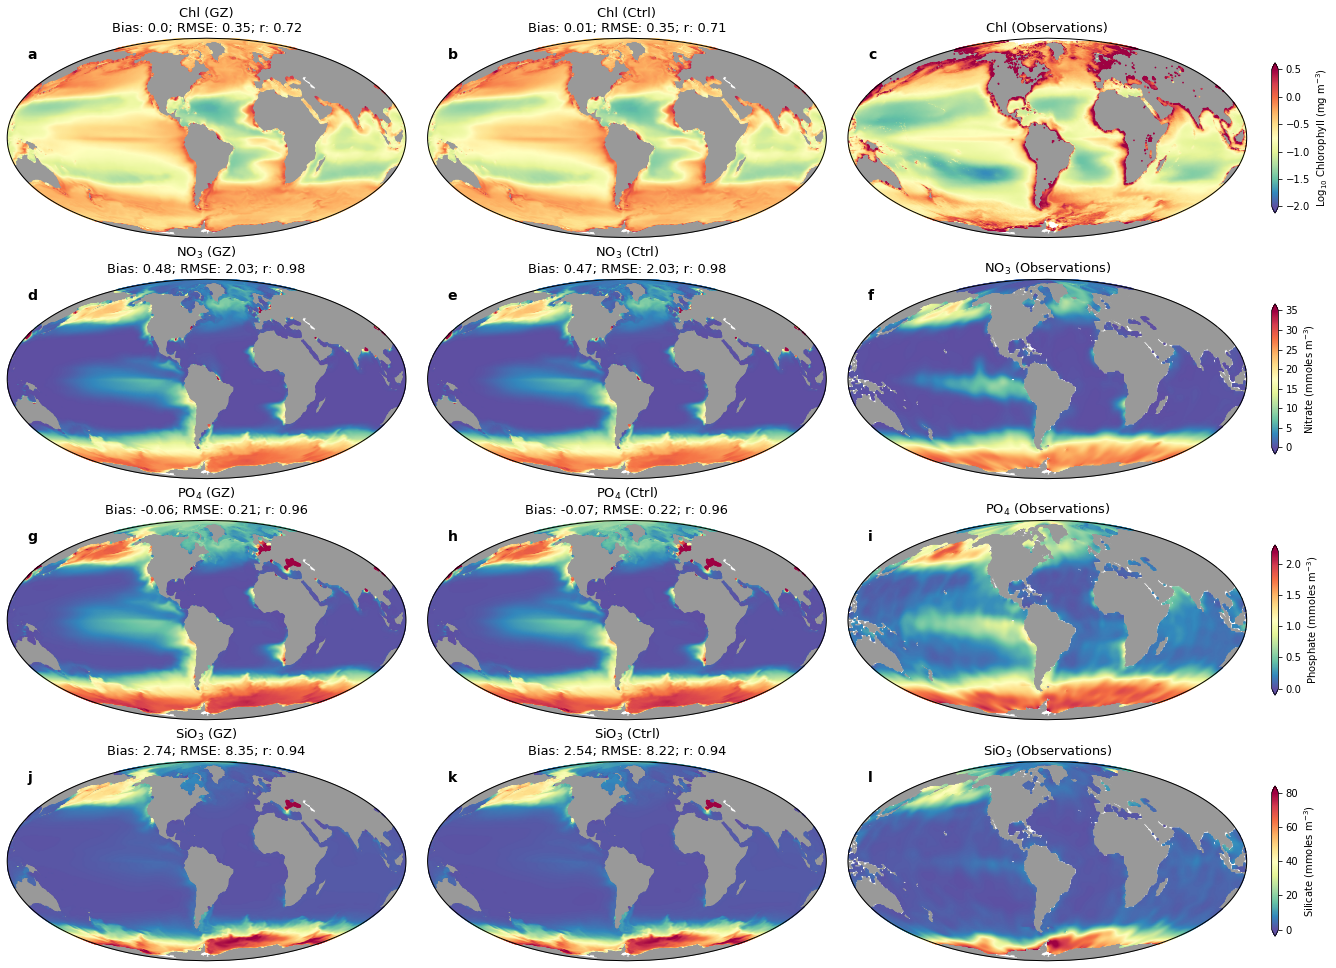

In [29]:
fig=plt.figure(figsize=(24,17))
gs=gridspec.GridSpec(4,3, wspace=0.05, width_ratios=[1,1,1.25])

ax={};cs={}

# Chl
i=0
ax[i] = plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=np.log10(chl_ann.isel(z_l=0)), transform=ccrs.PlateCarree(), vmin=-2,vmax=.5, cmap='Spectral_r')
ax[i].set_title('Chl (GZ)\nBias: ' + str(np.round(chl_bias.values,2)) + '; RMSE: ' + str(np.round(chl_rmse.values,2)) + '; r: ' + str(np.round(chl_pearsonsR,2)), fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

i=1
ax[i] = plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=np.log10(c_chl_ann.isel(z_l=0)), transform=ccrs.PlateCarree(), vmin=-2,vmax=.5, cmap='Spectral_r')
ax[i].set_title('Chl (Ctrl)\nBias: ' + str(np.round(c_chl_bias.values,2)) + '; RMSE: ' + str(np.round(c_chl_rmse.values,2)) + '; r: ' + str(np.round(c_chl_pearsonsR,2)), fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

i=2
ax[i] = plt.subplot(gs[0,2],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=np.log10(obs_chl.chl), transform=ccrs.PlateCarree(), vmin=-2,vmax=.5, cmap='Spectral_r')
ax[i].set_title('Chl (Observations)', fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

cb1 =plt.colorbar(cs[i], shrink=0.75, extend='both')
cb1.ax.set_ylabel('Log$_{10}$ Chlorophyll (mg m$^{-3}$)')


# NO3
i=3
ax[i] = plt.subplot(gs[1,0],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=no3_ann.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=35, cmap='Spectral_r')
ax[i].set_title('NO$_3$ (GZ)\nBias: ' + str(np.round(no3_bias.values,2)) + '; RMSE: ' + str(np.round(no3_rmse.values,2)) + '; r: ' + str(np.round(no3_pearsonsR,2)), fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

i=4
ax[i] = plt.subplot(gs[1,1],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=c_no3_ann.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=35, cmap='Spectral_r')
ax[i].set_title('NO$_3$ (Ctrl)\nBias: ' + str(np.round(c_no3_bias.values,2)) + '; RMSE: ' + str(np.round(c_no3_rmse.values,2)) + '; r: ' + str(np.round(c_no3_pearsonsR,2)), fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

i=5
ax[i] = plt.subplot(gs[1,2],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=obs_no3.n_an.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=35, cmap='Spectral_r')
ax[i].set_title('NO$_3$ (Observations)', fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

cb2 = plt.colorbar(cs[i], shrink=0.75, extend='both')
cb2.ax.set_ylabel('Nitrate (mmoles m$^{-3}$)')


# PO4
i=6
ax[i] = plt.subplot(gs[2,0],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=po4_ann.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=2.2, cmap='Spectral_r')
ax[i].set_title('PO$_4$ (GZ)\nBias: ' + str(np.round(po4_bias.values,2)) + '; RMSE: ' + str(np.round(po4_rmse.values,2)) + '; r: ' + str(np.round(po4_pearsonsR,2)), fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

i=7
ax[i] = plt.subplot(gs[2,1],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=c_po4_ann.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=2.2, cmap='Spectral_r')
ax[i].set_title('PO$_4$ (Ctrl)\nBias: ' + str(np.round(c_po4_bias.values,2)) + '; RMSE: ' + str(np.round(c_po4_rmse.values,2)) + '; r: ' + str(np.round(po4_pearsonsR,2)), fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

i=8
ax[i] = plt.subplot(gs[2,2],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=obs_po4.p_an.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=2.2, cmap='Spectral_r')
ax[i].set_title('PO$_4$ (Observations)', fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

cb3 = plt.colorbar(cs[i], shrink=0.75, extend='both')
cb3.ax.set_ylabel('Phosphate (mmoles m$^{-3}$)')

# SiO3
i=9
ax[i] = plt.subplot(gs[3,0],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=sio3_ann.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=80, cmap='Spectral_r')
ax[i].set_title('SiO$_3$ (GZ)\nBias: ' + str(np.round(sio3_bias.values,2)) + '; RMSE: ' + str(np.round(sio3_rmse.values,2)) + '; r: ' + str(np.round(sio3_pearsonsR,2)), fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

i=10
ax[i] = plt.subplot(gs[3,1],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=c_sio3_ann.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=80, cmap='Spectral_r')
ax[i].set_title('SiO$_3$ (Ctrl)\nBias: ' + str(np.round(c_sio3_bias.values,2)) + '; RMSE: ' + str(np.round(c_sio3_rmse.values,2)) + '; r: ' + str(np.round(c_sio3_pearsonsR,2)), fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

i=11
ax[i] = plt.subplot(gs[3,2],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].scatter(grid.geolon, grid.geolat, s=0.5, c=obs_sio3.i_an.isel(z_l=0), transform=ccrs.PlateCarree(), vmin=0,vmax=80, cmap='Spectral_r')
ax[i].set_title('SiO$_3$ (Observations)', fontsize=13)
ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=14, fontweight='bold', va='top')

cb4 = plt.colorbar(cs[i], shrink=0.75, extend='both')
cb4.ax.set_ylabel('Silicate (mmoles m$^{-3}$)')

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_SurfaceChl_Nutrients.png', dpi=300, bbox_inches='tight')

## Chlorophyll seasonal cycle

In [30]:
# load biomes
biomes = xr.open_dataset('biomes/'+short_casename+'_'+pp_dates+'_biomes.nc')

# control biomes
cbiomes = xr.open_dataset('biomes/gzCOBALT-Control-062321_1988-2007_biomes.nc')

In [31]:
dss = ds.drop([v for v in ds if v not in ['chl']]).isel(z_l=0)
dcs = dc.drop([v for v in dc if v not in ['chl']]).isel(z_l=0)

dss = dss.assign_coords(time=np.arange(1,13))
dcs = dcs.assign_coords(time=np.arange(1,13))

In [32]:
for var in ['chl']:
    SH_subset = dss[var].where(ds.yh < 0,drop=True).values
    SH_subset = np.roll(SH_subset, shift=6, axis=0)
    full_field = dss[var].values
    full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset

    svar = var + '_shift'
    dss[svar] = xr.DataArray(full_field, dims=dss[var].dims, coords=dss[var].coords)

dss

<xarray.Dataset>
Dimensions:    (nv: 2, time: 12, xh: 720, yh: 576, z_i: 36)
Coordinates:
  * xh         (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh         (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    z_l        float64 2.5
  * z_i        (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * nv         (nv) float64 1.0 2.0
Data variables:
    chl        (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    chl_shift  (time, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    filename:          ocean_cobalt_fdet_100.1988-1992.01.nc
    title:             OM4p5_CORE2_IAF_gzCOBALT-013022
    associated_files:  areacello: 19880101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    comment:           FMS time averaging, version 3.0, precision=double
    history:           Wed Feb 16 10:32:11 2022: ncra -O /archive/Jessica.Luo...
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....

In [33]:
for var in ['chl']:
    SH_subset = dcs[var].where(dc.yh < 0,drop=True).values
    SH_subset = np.roll(SH_subset, shift=6, axis=0)
    full_field = dcs[var].values
    full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset

    svar = var + '_shift'
    dcs[svar] = xr.DataArray(full_field, dims=dcs[var].dims, coords=dcs[var].coords)

dcs

<xarray.Dataset>
Dimensions:    (nv: 2, time: 12, xh: 720, yh: 576, z_i: 36)
Coordinates:
  * xh         (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh         (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    z_l        float64 2.5
  * z_i        (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * nv         (nv) float64 1.0 2.0
Data variables:
    chl        (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    chl_shift  (time, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    filename:          ocean_cobalt_fdet_100.1988-1992.01.nc
    title:             OM4p5_CORE2_IAF_gzCOBALT-Control-062321
    associated_files:  areacello: 19880101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    comment:           FMS time averaging, version 3.0, precision=double
    history:           Tue Jul  6 13:48:31 2021: ncra -O /archive/Jessica.Luo...
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....

In [34]:
c1='#1b9e77'#'#440154FF'
c2='#d95f02'#'#21908CFF'
c3='#7570b3'#'#FDE725FF'

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c1, lw=2),
                Line2D([0], [0], color=c2, lw=2),
                Line2D([0], [0], color=c3, lw=2),
                Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='k', ls='--', lw=2)]

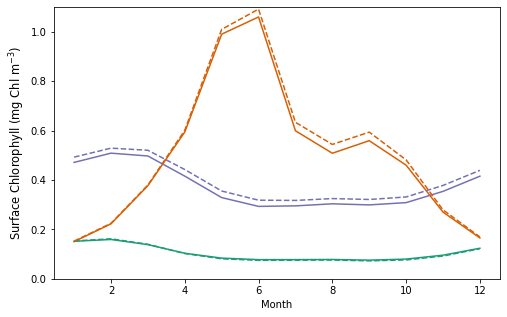

In [35]:
plt.figure(figsize=(8,5))

ymax1 = 1.1
(dss.chl_shift.where(biomes.biomes==1).mean(dim=['xh','yh'])*1e6).plot(c=c1, ylim=(0,ymax1))
(dss.chl_shift.where(biomes.biomes==2).mean(dim=['xh','yh'])*1e6).plot(c=c2)
(dss.chl_shift.where(biomes.biomes==3).mean(dim=['xh','yh'])*1e6).plot(c=c3)
(dcs.chl_shift.where(cbiomes.biomes==1).mean(dim=['xh','yh'])*1e6).plot(c=c1,ls='--')
(dcs.chl_shift.where(cbiomes.biomes==2).mean(dim=['xh','yh'])*1e6).plot(c=c2,ls='--')
(dcs.chl_shift.where(cbiomes.biomes==3).mean(dim=['xh','yh'])*1e6).plot(c=c3,ls='--')
plt.gca().set_ylabel('Surface Chlorophyll (mg Chl m$^{-3}$)', fontsize=11.5)
plt.gca().set_xlabel('Month')
plt.gca().set_title('')

plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_ChlSeasonalCycle.png', dpi=300, bbox_inches='tight')